In [1]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
from IPython.display import clear_output
from google.colab import files
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications.vgg19 import preprocess_input
from PIL import Image

torch.cuda.empty_cache()
gpu_name = tf.test.gpu_device_name()
cpu_name = '/cpu:0'
print(gpu_name)

TensorFlow 2.x selected.
/device:GPU:0


In [2]:
download = False
if download:
  VGG19 = vgg19.VGG19(include_top=False, weights='imagenet') 
  VGG19.trainable = False
  #tf.keras.models.save_model(VGG19, 'drive/My Drive/VGG19.h5')
else:
  VGG19 = tf.keras.models.load_model('drive/My Drive/VGG19.h5')
  #VGG19.trainable = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def model_maker():
  content_layer_name = ['block4_conv2'] 
  style_layers_name = ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1',
                        'block4_conv1',
                        'block5_conv1']
  layers = style_layers_name + content_layer_name
  core_layers = [VGG19.get_layer(layer).output for layer in layers]
  DeepSynthCore = models.Model(VGG19.input, core_layers)
  return DeepSynthCore

In [0]:
def content_loss(output, content, model):
  R_C = model.predict(output)[5]
  return tf.reduce_mean(tf.square(R_C-content))

In [0]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [0]:
def get_style_loss(gram1, gram2):
  return tf.reduce_mean(tf.square(gram1 - gram2))

In [0]:
def style_loss_func(gram_style, gram_product, weights):
  Loss = 0
  W = [100, 10, 10**-2, 10**-2, 100]
  w = [10, 10, 5, 1, 1]
  v = [1, 1, 5, 10, 10]
  c = [10, 0, 0, 0, 0]
  d = [100, 10, 1, 1, 10]
  e = [1,1,1,1,1]
  #c = [1,1,1,1,1]
  for i in range(5):
    Loss += get_style_loss(gram_style[i], gram_product[i])*weights[i]
  Loss = Loss/sum(weights)
  return Loss

In [0]:
def content_loss_func(feature_output, feature_content):
  return tf.reduce_mean(tf.square(feature_output - feature_content))

In [0]:
def logger(product_image, i, closs, sloss, L, ratio, losses):
      clear_output(wait=True)
      plt.figure(figsize=(8, 6))
      plt.subplot(121)
      plt.imshow(np.array(product_image[0,:,:,:]+np.array([103.939, 116.779, 123.68])).astype('uint8')[:,:,::-1])
      plt.subplot(122)
      plt.plot(losses)
      print('%3d [L_C %.3e] [L_S %.3e] [Loss %.3e] [C/S %.2e]'%(i,
                                                                closs,
                                                                sloss,
                                                                L,
                                                                ratio))
      plt.show()
      log = open('drive/My Drive/ED/log.txt', 'w')
      log.write('ITERATION %3d'%(i))
      log.close()

In [0]:
def image_loader(filename, max_pix_length):
  image = Image.open(filename)
  w, h = image.size
  W, H = int(w*max_pix_length/max(w, h)), int(h*max_pix_length/max(w, h))
  input_size = (W, H)
  image = image.resize(input_size)
  image = np.array(image).astype('float32')
  image = tf.reshape(image, (1, *image.shape))
  image = preprocess_input(image)
  return image

In [0]:
def style_transfer(content_image_tensor, style_image_tensor, 
                   product_image_tensor,
                   max_iter,
                   W_C, W_S, style_layers_weights,
                   LR, neural_model,
                   name):
  ## Setup and clean-up
  torch.cuda.empty_cache()
  optimizer = tf.keras.optimizers.Adam(learning_rate = LR)
  ## Constants
  loss_history = []
  MIN = np.inf
  norm_means = np.array([103.939, 116.779, 123.68])
  style_image_features = neural_model(style_image_tensor)[:5]
  content_image_features = neural_model(content_image_tensor)[5]
  gram_list_style = [gram_matrix(feature) for feature in style_image_features]
  ## Image generation core
  with tf.device(gpu_name):
    total_runtime = time.time()
    for iteration in range(max_iter):
      start_time = time.time()
      product_image_tensor = tf.Variable(product_image_tensor)
      with tf.GradientTape() as grad:
        grad.watch(product_image_tensor)
        *style_features, content_feature = neural_model(product_image_tensor)
        gram_list_product = [gram_matrix(style_feature) for style_feature in style_features]
        content_loss = content_loss_func(content_feature,
                                        content_image_features)*W_C
        style_loss = style_loss_func(gram_list_style,
                                    gram_list_product,
                                    style_layers_weights)*W_S
        ratio = (content_loss/style_loss)
        total_loss = content_loss + style_loss
        loss_history.append(total_loss)
      dy_dx = grad.gradient(total_loss, product_image_tensor)
      optimizer.apply_gradients([(dy_dx, product_image_tensor)])
      product_image_tensor = tf.clip_by_value(product_image_tensor, 
                                              -norm_means, 
                                              255-norm_means)
      if not iteration%10:
        logger(product_image_tensor, iteration, content_loss, 
              style_loss, total_loss, ratio, loss_history)
        iter_time = time.time()-start_time
        eta = (max_iter-iteration)*iter_time
        minutes, seconds = eta//60, eta%60
        print("Batch\t\t%8.3f (s)\nE.T.A\t\t%8.3f (s) %2dm %2ds"%(iter_time,
                                                                  eta,
                                                                  minutes,
                                                                  seconds))
      if (not iteration%200) and iteration:
        torch.cuda.empty_cache()
      if total_loss < MIN:
        best = product_image_tensor
        MIN = total_loss
    print("Total Runtime:\t%8.3f (s)"%(time.time()-total_runtime))
    values = (name, W_S, W_C, max_iter, LR, style_layers_weights)
    model_text = '%sS%.1e-C%.1e-%5d-LR%.1e-[W%s]'%values
    return product_image_tensor, best, model_text

In [0]:
def image_saver(filename, image_tensor):
  final = np.array(image_tensor[0,:,:,:]+np.array([103.939, 116.779, 123.68]))
  final = final.astype('uint8')[:,:,::-1]
  plt.imshow(final)
  Image.fromarray(final).save(filename+'.png')
  files.download(filename+'.png')
  return final

In [0]:
cConvNum = 5
DeepTransfer = model_maker()
## Pre-process
cname = 'challenger'
sname = 'ccc'
Name = 'DeepTransfer-%s+%s-'%(cname, sname)
bigside = 600

# Image 1: Content carrier
content_image_tensor = image_loader('drive/My Drive/ED/%s.jpg'%(cname), bigside)

# Image 2: Style carrier
style_image_tensor = image_loader('drive/My Drive/ED/%s.jpg'%(sname), bigside)

# Image 3: Product carrier
product_image_tensor = content_image_tensor
# Config
input_kwargs = {"content_image_tensor" : content_image_tensor,
                "style_image_tensor" : style_image_tensor,
                "product_image_tensor" : product_image_tensor,
                "max_iter" : 200,
                "W_C" : 1e+0,
                "W_S" : 1e+4,
                "LR" : 1e0,
                "style_layers_weights" : np.array([1, 1, 1, 1, 1]),
                "neural_model" : DeepTransfer,
                "name" : Name
                }

190 [L_C 5.098e+05] [L_S 8.513e+12] [Loss 8.513e+12] [C/S 5.99e-08]


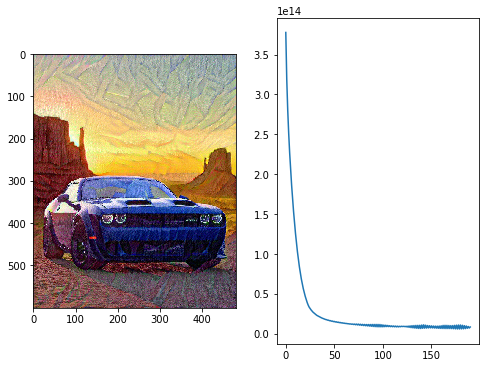

Batch		   0.705 (s)
E.T.A		   7.051 (s)  0m  7s
Total Runtime:	  30.000 (s)


In [15]:
product_image_tensor, best_prod, filename = style_transfer(**input_kwargs)
#image_saver(filename)

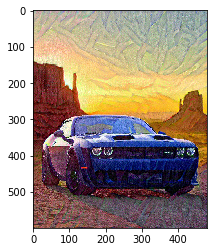

In [16]:
final_image = image_saver(filename, best_prod)

In [17]:
Error Maker!

SyntaxError: ignored

In [0]:
def feature_show(n_filters = 10, save=False):
  fig = plt.figure(figsize=(20, 20))
  num = 0
  for layer in range(5):
    print(layer)
    _,_,N = DeepTransfer(sty)[layer][0,:,:,:].shape
    R = np.random.randint(N, size=(n_filters))
    for i in range(n_filters):
      num += 1
      plt.subplot(5, n_filters, num)
      p = DeepTransfer(sty)[layer][0,:,:,R[i]]
      plt.imshow(p)
  if save:
    plt.savefig('X.png')
    files.download('X.png')

In [0]:
feature_show(10)